In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from urllib.parse import quote
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# carga do dataset
uci_url = 'https://archive.ics.uci.edu/static/public/697/'
predict_student_file = 'predict+students+dropout+and+academic+success.zip'
request = urllib.request.urlopen(uci_url + urllib.parse.quote(predict_student_file))
zipfile = ZipFile(BytesIO(request.read()))
filepath = TextIOWrapper(zipfile.open('data.csv'), encoding='utf-8')
dataset = pd.read_csv(filepath, sep=';')

dataset.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [3]:
# preparação dos dados

# separação em bases de treino e teste (holdout)
array = dataset.values
X = array[:,0:36]
Y = array[:,36]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=7, stratify=Y)

# criando os folds para a validação cruzada
num_splits = 10
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=7)

KNN: 0.591967 (0.025781)
CART: 0.682099 (0.031703)
NB: 0.686352 (0.021846)
SVM: 0.499294 (0.015124)
LR: 0.692291 (0.027519)
Bagging: 0.769421 (0.017360)
RF: 0.771401 (0.018544)
ET: 0.767444 (0.017020)
Ada: 0.754164 (0.020462)
GB: 0.773374 (0.018234)
Voting: 0.702461 (0.026564)


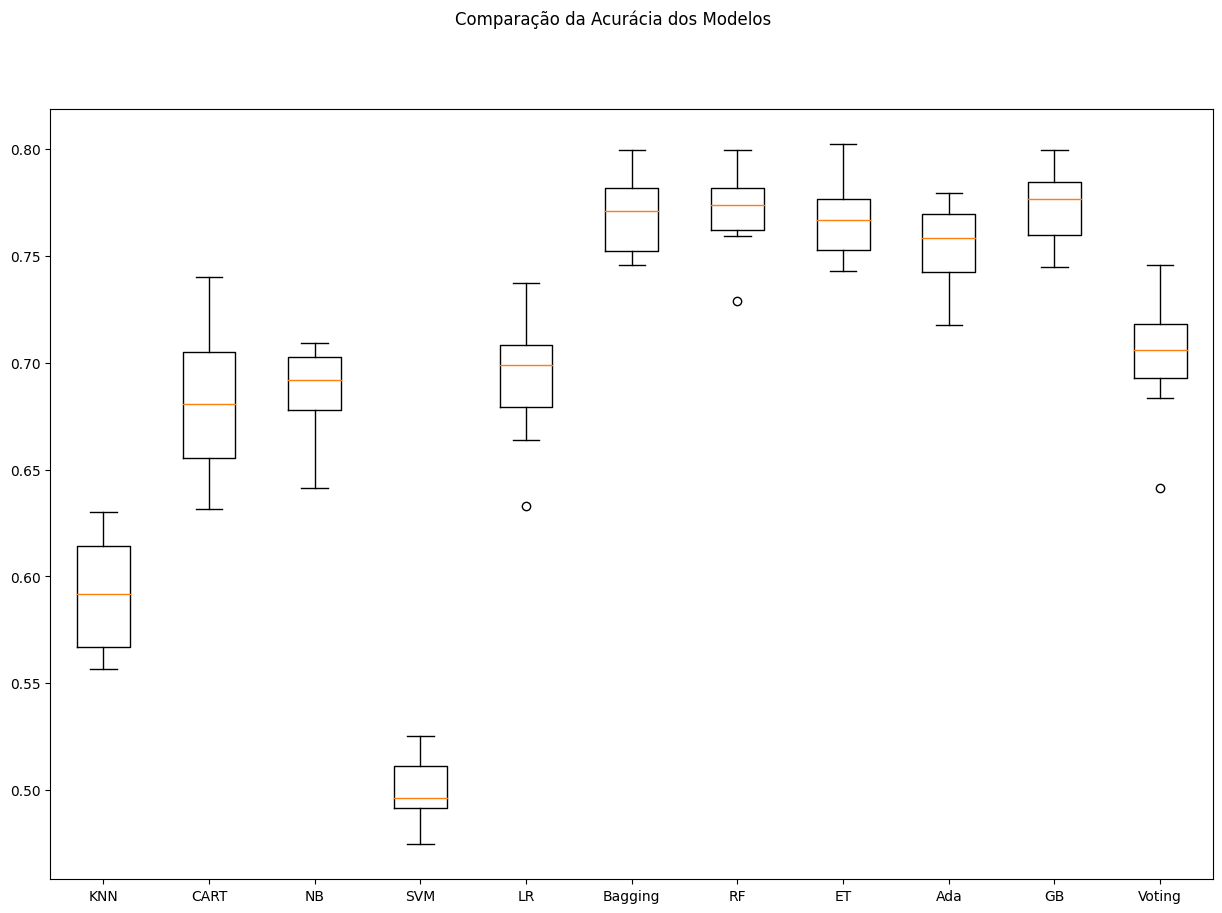

In [4]:
# modelagem

# definindo uma seed global para esta célula de código
np.random.seed(7)

# listas para aramazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# preparando os modelos e adicionando-os em uma lista
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
models.append(('LR', LogisticRegression(max_iter=200)))

# definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('Logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# criando os ensembles e adicionando na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))


# avaliando um modelo por vez
for name, model in models:
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot de comparação de modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [5]:
# lista para armazenar os pipelines
pipelines = []

# criando os elementos do pipeline

# algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# transformações que serão utilizadas
standard_scalar = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

In [6]:
# criando um modelo com todo o conjunto de treino
model = GaussianNB()
model.fit(X_train, Y_train)

# fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# estimando a acurácia no conjunto de teste
print(accuracy_score(Y_test, predictions))

0.6836158192090396
